In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from datetime import timedelta
import matplotlib.dates as mdates
plt.rc('font', family='NanumBarunGothic') 

#에러 제거
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler # down
from imblearn.over_sampling import RandomOverSampler, SMOTE  # up, smote
from imblearn.combine import SMOTEENN
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


from tqdm import tqdm
import shap


In [46]:
df = pd.read_csv('pr_tr_cu_n2.csv')

In [47]:
df.head().T

,0,1,2,3,4
created_at,2018-07-29 15:22:01.458193+00:00,2018-07-30 12:40:22.365620+00:00,2018-09-15 11:51:17.365620+00:00,2018-11-01 11:23:48.365620+00:00,2018-12-18 11:20:30.365620+00:00
customer_id,5868,4774,4774,4774,4774
session_id,3abaa6ce-e320-4e51-9469-d9f3fa328e86,2ee5ead1-f13e-4759-92df-7ff48475e970,93325fb6-eb00-4268-bb0e-6471795a0ad0,bcad5a61-1b67-448d-8ff4-781d67bc56e4,df1042ab-13e6-4072-b9d2-64a81974c51a
payment_method,Debit Card,Credit Card,OVO,Credit Card,Credit Card
payment_status,Success,Success,Success,Success,Success
promo_amount,1415,0,0,0,0
promo_code,WEEKENDSERU,nopromo,nopromo,nopromo,nopromo
shipment_fee,10000,10000,10000,0,0
product_id,54728,16193,53686,20228,55220
quantity,1,1,4,1,1


In [48]:
df['created_at'] = pd.to_datetime(df['created_at'])  # 날짜 형식으로 변환

# customer_id를 기준으로 정렬 후, 다음 구매 일자 계산
df.sort_values(by=['customer_id', 'created_at'], inplace=True)
df['next_purchase'] = df.groupby('customer_id')['created_at'].shift(-1)

# 다음 구매 일자와의 차이 계산
df['time_to_next_purchase'] = df['next_purchase'] - df['created_at']

df['time_to_next_purchase'] = df['time_to_next_purchase'].dt.days.astype(str) + ' days'

df['time_to_next_purchase'] = df['time_to_next_purchase'].apply(lambda x: x.split('.')[0])

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1330164 entries, 372869 to 1275196
Data columns (total 31 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   created_at             1330164 non-null  datetime64[ns, UTC]
 1   customer_id            1330164 non-null  int64              
 2   session_id             1330164 non-null  object             
 3   payment_method         1330164 non-null  object             
 4   payment_status         1330164 non-null  object             
 5   promo_amount           1330164 non-null  int64              
 6   promo_code             1330164 non-null  object             
 7   shipment_fee           1330164 non-null  int64              
 8   product_id             1330164 non-null  int64              
 9   quantity               1330164 non-null  int64              
 10  item_price             1330164 non-null  int64              
 11  shipment_date          1

In [50]:
df.head().T

,372869,372870,372871,372872,372873
created_at,2018-08-25 18:54:03.844494+00:00,2018-09-22 18:42:52.844494+00:00,2018-10-20 19:07:54.844494+00:00,2018-11-17 19:09:49.844494+00:00,2018-12-15 19:33:50.844494+00:00
customer_id,3,3,3,3,3
session_id,f03b6825-1e6e-4916-bf71-f94ecbcbaee5,36673b2f-940a-42b5-994d-1cce4796b55f,93e1d3c4-bed1-4ef4-b79f-e24a79e905b7,8356370c-267e-4530-a2d3-1830e4be3f2b,ef7f4829-e7d1-4513-861b-1fbbc6e41bbf
payment_method,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card
payment_status,Success,Success,Success,Success,Success
promo_amount,8073,0,8828,3415,2645
promo_code,WEEKENDMANTAP,nopromo,WEEKENDSERU,WEEKENDSERU,LIBURDONG
shipment_fee,0,10000,10000,0,10000
product_id,56019,30235,7808,48968,59272
quantity,5,1,1,1,1


In [51]:
df['time_to_next_purchase'] = df['time_to_next_purchase'].replace('nan days', 1)

In [52]:
df['time_to_next_purchase'] = df['time_to_next_purchase'].astype('int64')
df['used'] = df['used'].astype('int64')

In [53]:
df['chun'] = df['time_to_next_purchase'].apply(lambda x: 1 if x > 32 else 0)

In [25]:
# 결제 실패는 다 이탈로 분류
#df.loc[df['payment_status'] == 'Failed', 'chun'] = 0

In [54]:
# 프로모션 사용은 1 미사용은 0으로 변경 
df['promo_use'] = df['promo_code'].apply(lambda x: 0 if x == 'nopromo' else 1)

In [56]:
df.to_csv("pr_tr_cu_n.csv", index=False)

In [2]:
df = pd.read_csv('pr_tr_cu_n.csv')

In [3]:
df.head().T

,0,1,2,3,4
created_at,2018-08-25 18:54:03.844494+00:00,2018-09-22 18:42:52.844494+00:00,2018-10-20 19:07:54.844494+00:00,2018-11-17 19:09:49.844494+00:00,2018-12-15 19:33:50.844494+00:00
customer_id,3,3,3,3,3
session_id,f03b6825-1e6e-4916-bf71-f94ecbcbaee5,36673b2f-940a-42b5-994d-1cce4796b55f,93e1d3c4-bed1-4ef4-b79f-e24a79e905b7,8356370c-267e-4530-a2d3-1830e4be3f2b,ef7f4829-e7d1-4513-861b-1fbbc6e41bbf
payment_method,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card
payment_status,Success,Success,Success,Success,Success
promo_amount,8073,0,8828,3415,2645
promo_code,WEEKENDMANTAP,nopromo,WEEKENDSERU,WEEKENDSERU,LIBURDONG
shipment_fee,0,10000,10000,0,10000
product_id,56019,30235,7808,48968,59272
quantity,5,1,1,1,1


In [4]:
# 모델 분석을 위해 불필요한 컬럼 삭제
columns_to_drop = ['customer_id', 'created_at', 'session_id', 'age_group', 'next_purchase', 'time_to_next_purchase', 'product_id', 'promo_code',
'promo_amount', 'shipment_fee']
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
'masterCategory', 'subCategory', 'articleType', 'usage', 'brand', 'promo_code', 'baseColour', 'season', 'gender_x', 'device_type', 'home_location'

In [5]:
df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
payment_method,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,LinkAja,Gopay,Gopay,Credit Card,Credit Card,Credit Card,Debit Card,Credit Card,Credit Card,Credit Card,Credit Card,Debit Card
payment_status,Success,Success,Success,Success,Success,Failed,Success,Success,Success,Success,Success,Success,Success,Success,Success,Success,Success,Success,Success,Success
quantity,5,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1,2,2,1,1
item_price,166934,153784,123760,251317,173882,217298,376296,303471,337328,338495,250464,194391,209865,493973,130349,300712,111094,162990,326640,305226
shipment_date,1,3,5,3,3,2,4,4,3,3,3,4,3,3,4,4,5,1,1,3
total_cost,834670,153784,123760,251317,173882,217298,376296,303471,337328,676990,250464,194391,209865,987946,260698,300712,222188,325980,326640,305226
customer_type,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
price_category,저가,저가,저가,중가,중가,중가,고가,중가,고가,고가,중가,중가,중가,고가,저가,중가,저가,저가,고가,중가
gender_x,Women,Men,Men,Men,Women,Men,Men,Unisex,Men,Men,Women,Girls,Women,Women,Men,Women,Men,Men,Men,Women
masterCategory,Personal Care,Footwear,Apparel,Accessories,Accessories,Apparel,Apparel,Accessories,Apparel,Personal Care,Apparel,Apparel,Apparel,Apparel,Footwear,Footwear,Accessories,Apparel,Apparel,Personal Care


코드 전체적인 숫자 변경작업

chun
0    1060402
1     269762
Name: count, dtype: int64
chun
0    0.797196
1    0.202804
Name: proportion, dtype: float64


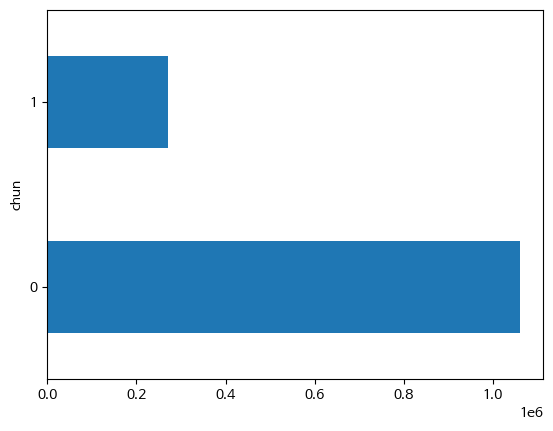

In [6]:
print(df['chun'].value_counts())
print(df['chun'].value_counts(normalize = True))

df['chun'].value_counts().plot(kind = 'barh')
plt.show()

In [7]:
# X,y로 나누기
target = 'chun'
X = df.drop(target, axis=1)
y = df[target]

# train, validation, test 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=42)

# 확인
print('학습용:', X_train.shape, y_train.shape)
print('검증용:', X_val.shape, y_val.shape)
print('평가용:', X_test.shape, y_test.shape)

학습용: (851304, 22) (851304,)
검증용: (212827, 22) (212827,)
평가용: (266033, 22) (266033,)


In [8]:
# 기준 모델 생성
baseline = [y_train.mode()[0]] * len(y_train)

훈련 정확도 0.7971958313363968
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    678656
           1       0.00      0.00      0.00    172648

    accuracy                           0.80    851304
   macro avg       0.40      0.50      0.44    851304
weighted avg       0.64      0.80      0.71    851304



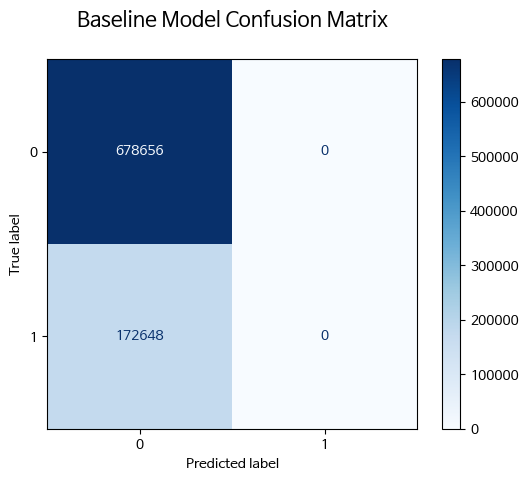

In [9]:
# Classification report
print("훈련 정확도", accuracy_score(y_train, baseline))
print(
    classification_report(
        y_train, baseline)
    )

# Confusion matrix
cm = confusion_matrix(y_train, baseline)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Baseline Model Confusion Matrix\n", size=15)
plt.show()

훈련 정확도:  0.7971958313363968
검증 정확도:  0.7971967842426008
평가 정확도:  0.7971980919660343
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    169665
           1       0.00      0.00      0.00     43162

    accuracy                           0.80    212827
   macro avg       0.40      0.50      0.44    212827
weighted avg       0.64      0.80      0.71    212827



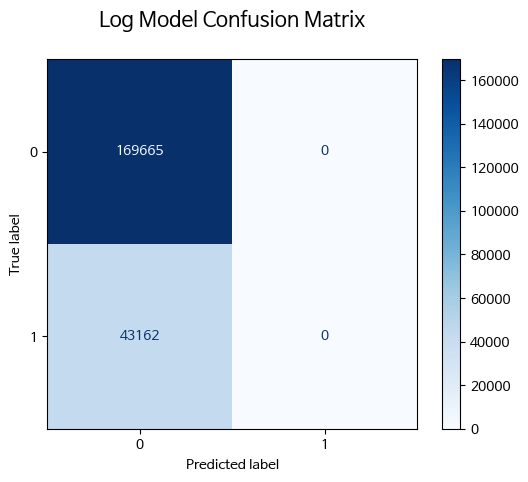

In [10]:
# Log 모델 파이프라인 생성
pipe_Log = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        LogisticRegression(random_state = 42)
)

# 모델 학습
pipe_Log.fit(X_train, y_train)

# 모델 검증
y_pred_val = pipe_Log.predict(X_val)

# 정확도 확인
print('훈련 정확도: ', pipe_Log.score(X_train, y_train))
print('검증 정확도: ', pipe_Log.score(X_val, y_val))
print('평가 정확도: ', pipe_Log.score(X_test, y_test))

# Classification report
print(
    classification_report(
        y_val, y_pred_val)
    )

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Log Model Confusion Matrix\n", size=15)
plt.show()

훈련 정확도:  0.9969787525960174
검증 정확도:  0.7943681957646351
평가 정확도:  0.7944916608089974
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    169665
           1       0.09      0.00      0.00     43162

    accuracy                           0.79    212827
   macro avg       0.44      0.50      0.44    212827
weighted avg       0.65      0.79      0.71    212827



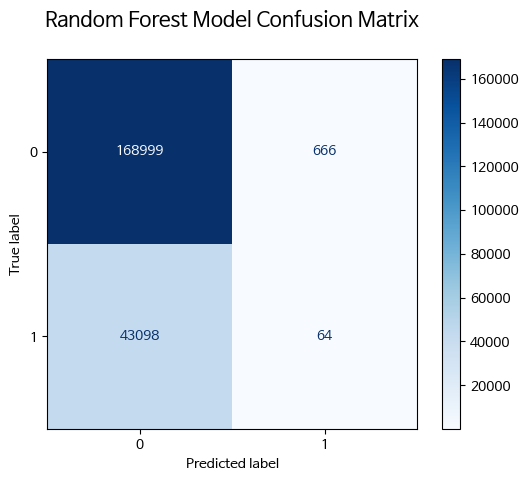

In [11]:
# RandomForest 모델 파이프라인 생성
pipe_rf = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        RandomForestClassifier(random_state = 42)
)

# 모델 학습
pipe_rf.fit(X_train, y_train)

# 모델 검증
y_pred_val = pipe_rf.predict(X_val)

# 정확도 확인
print('훈련 정확도: ', pipe_rf.score(X_train, y_train))
print('검증 정확도: ', pipe_rf.score(X_val, y_val))
print('평가 정확도: ', pipe_rf.score(X_test, y_test))

# Classification report
print(
    classification_report(
        y_val, y_pred_val)
    )

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Random Forest Model Confusion Matrix\n", size=15)
plt.show()

훈련 정확도:  0.7986665163090976
검증 정확도:  0.7980425415948165
평가 정확도:  0.7979498783985446
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    169665
           1       0.65      0.01      0.02     43162

    accuracy                           0.80    212827
   macro avg       0.73      0.50      0.45    212827
weighted avg       0.77      0.80      0.71    212827



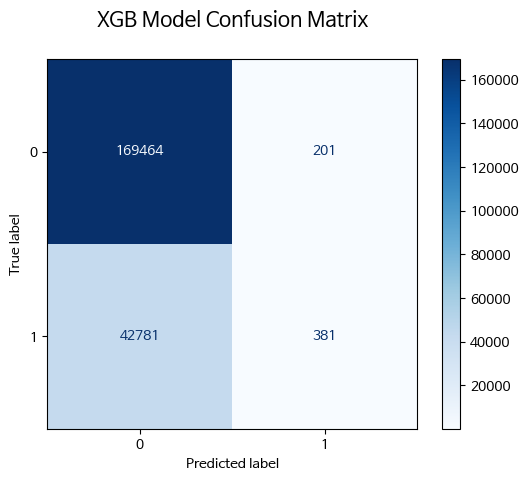

In [12]:
# XGB 모델 파이프라인 생성
pipe_xgb = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        XGBClassifier(random_state = 42)
)

# 모델 학습
pipe_xgb.fit(X_train, y_train)

# 모델 검증
y_pred_val = pipe_xgb.predict(X_val)

# 정확도 확인
print('훈련 정확도: ', pipe_xgb.score(X_train, y_train))
print('검증 정확도: ', pipe_xgb.score(X_val, y_val))
print('평가 정확도: ', pipe_xgb.score(X_test, y_test))

# Classification report
print(
    classification_report(
        y_val, y_pred_val)
    )

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("XGB Model Confusion Matrix\n", size=15)
plt.show()

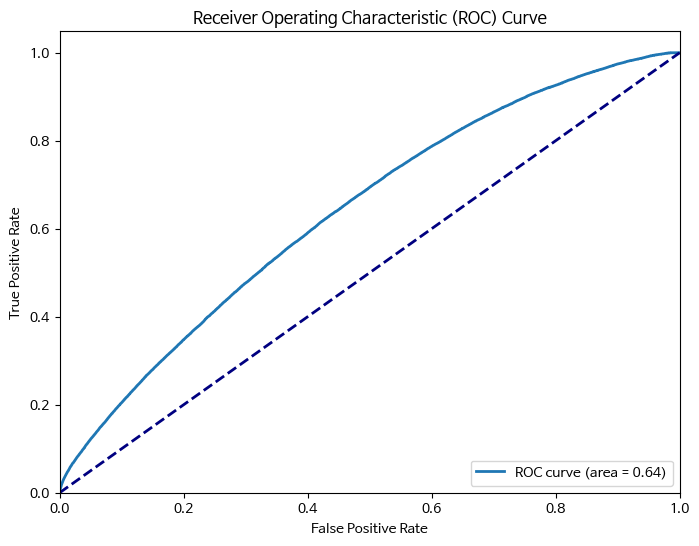

In [13]:
# 모델 검증
y_pred_val = pipe_xgb.predict(X_val)
y_pred_proba_val = pipe_xgb.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 예측 확률 추출

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_val)

# ROC 커브 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, y_pred_proba_val))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

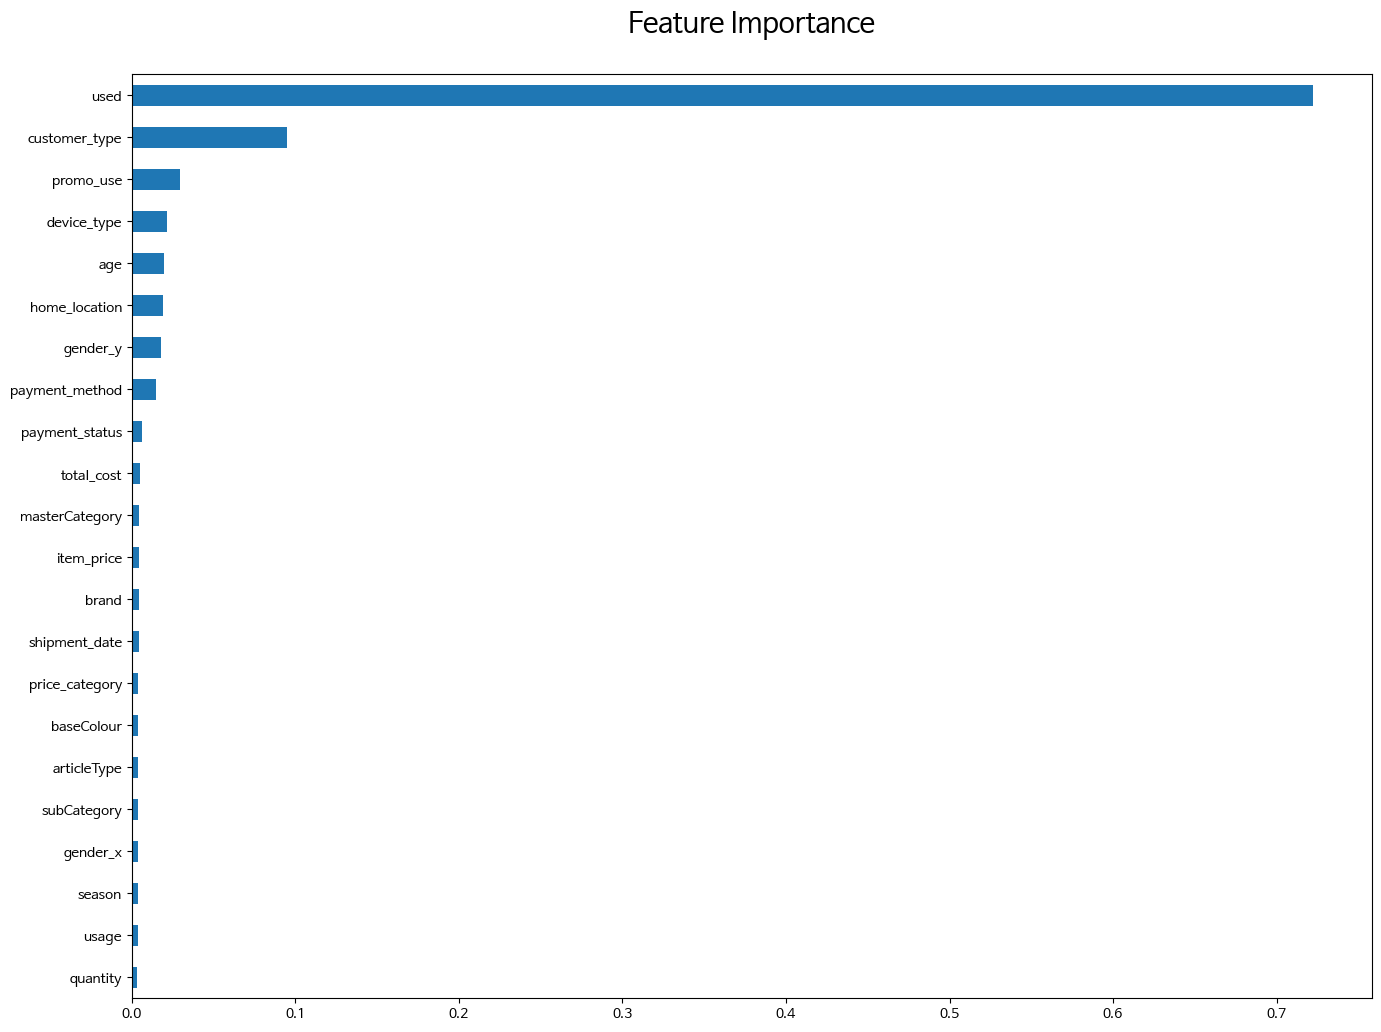

In [14]:
# 특성 중요도
xgb = pipe_xgb.named_steps["xgbclassifier"]
importances = pd.Series(xgb.feature_importances_, X_train.columns)
plt.figure(figsize=(16, 12))
importances.sort_values().plot.barh()
plt.title("Feature Importance\n", size=20)
plt.show()

In [ ]:
# 최적 파라미터 찾기기 위한 파이프 라인 구성 - 랜덤 서치
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum()
    ),
)

from scipy.stats.distributions import uniform

params = {
    "xgbclassifier__max_depth": [3,5,7,10,15],
    "xgbclassifier__learning_rate": [0.05, 0.1, 0.3],
    "xgbclassifier__n_estimators": [100,200,300,400,500],
    "xgbclassifier__colsample_bytree": [0.8,0.9]
}

from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    scoring={"recall": "recall", "roc_auc": "roc_auc"},
    refit="recall",
    cv=3,
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 AUC: ", randomized_search.best_score_)


[CV 1/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=400; recall: (test=0.700) roc_auc: (test=0.649) total time=11.1min
[CV 2/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=400; recall: (test=0.713) roc_auc: (test=0.653) total time=11.0min
[CV 3/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=400; recall: (test=0.709) roc_auc: (test=0.646) total time=11.0min


[CV 1/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200; recall: (test=0.802) roc_auc: (test=0.612) total time= 2.6min
[CV 2/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200; recall: (test=0.814) roc_auc: (test=0.613) total time= 2.6min
[CV 3/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200; recall: (test=0.812) roc_auc: (test=0.615) total time= 2.6min


[CV 1/3] END xgbclassifier__colsample_bytree=0.9, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=300; recall: (test=0.819) roc_auc: (test=0.607) total time= 3.9min
[CV 2/3] END xgbclassifier__colsample_bytree=0.9, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=300; recall: (test=0.824) roc_auc: (test=0.613) total time= 4.0min
[CV 3/3] END xgbclassifier__colsample_bytree=0.9, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=300; recall: (test=0.826) roc_auc: (test=0.609) total time= 3.9min
최적 하이퍼파라미터:  {'xgbclassifier__n_estimators': 200, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__colsample_bytree': 0.9}
최적 AUC:  0.8517156151201527


훈련 정확도:  0.5767504910114366
검증 정확도:  0.5433850028426844
평가 정확도:  0.5439964214965812
              precision    recall  f1-score   support

           0       0.88      0.50      0.63    169665
           1       0.27      0.73      0.39     43162

    accuracy                           0.54    212827
   macro avg       0.57      0.61      0.51    212827
weighted avg       0.75      0.54      0.59    212827



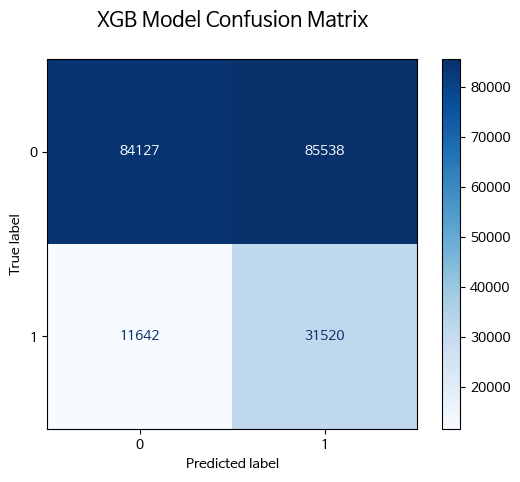

In [15]:
# XGB 모델 파이프라인 생성
pipe_xgb = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        XGBClassifier(
                            objective="binary:logistic",
                            random_state = 42,
                            eval_metric="error",
                            scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum(),
                            n_estimators = 400,
                            max_depth = 10,
                            learning_rate = 0.05,
                            colsample_bytree = 0.9,
                            n_jobs=-1,
                            )
)

# 모델 학습
pipe_xgb.fit(X_train, y_train)

# 모델 검증
y_pred_val = pipe_xgb.predict(X_val)

# 정확도 확인
print('훈련 정확도: ', pipe_xgb.score(X_train, y_train))
print('검증 정확도: ', pipe_xgb.score(X_val, y_val))
print('평가 정확도: ', pipe_xgb.score(X_test, y_test))

# Classification report
print(
    classification_report(
        y_val, y_pred_val)
    )

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("XGB Model Confusion Matrix\n", size=15)
plt.show()

훈련 정확도:  0.4488502344638343
검증 정확도:  0.44562015157851215
평가 정확도:  0.44665887314731634

              precision    recall  f1-score   support

           0       0.88      0.35      0.50    169665
           1       0.24      0.81      0.37     43162

    accuracy                           0.45    212827
   macro avg       0.56      0.58      0.44    212827
weighted avg       0.75      0.45      0.48    212827

In [16]:
# 최적 파라미터 찾기기 위한 파이프 라인 구성 - 그리드 서치
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        random_state=42,
        scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum(),
        n_jobs=-1,
    ),
)

params = {
    "xgbclassifier__max_depth": [10,14,16,18],
    "xgbclassifier__learning_rate": [0.05,0.07,0.1],
    "xgbclassifier__n_estimators": [300,400,600,800],
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, 
                           param_grid=params, 
                           scoring={"recall": "recall", "roc_auc": "roc_auc", "accuracy": "accuracy"}, 
                           refit="accuracy",
                           cv=2, 
                           verbose=3)
grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 accuracy: ", grid_search.best_score_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV 1/2] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=300; accuracy: (test=0.535) recall: (test=0.712) roc_auc: (test=0.646) total time=11.8min
[CV 2/2] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=300; accuracy: (test=0.529) recall: (test=0.712) roc_auc: (test=0.640) total time= 7.6min
[CV 1/2] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=400; accuracy: (test=0.565) recall: (test=0.678) roc_auc: (test=0.652) total time= 9.9min
[CV 2/2] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=400; accuracy: (test=0.554) recall: (test=0.675) roc_auc: (test=0.643) total time=10.2min
[CV 1/2] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=600; accuracy: (test=0.591) recall: (test=0.637) roc_a